In [2]:
from ast import literal_eval
import numpy as np
from atmos_cloud_sim_uj_utils import show_plot
from matplotlib import pyplot
from joblib import Parallel, delayed, parallel_backend

In [4]:
import os
os.environ["NUMBA_NUM_THREADS"] = "1"

In [15]:
from PySDM.physics import si
from PySDM.initialisation import discretise_multiplicities, equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.initialisation.sampling import spectral_sampling
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, Formulae, products

In [55]:
def run(**args):
    env = Parcel(
        dt = .1 * si.s,
        mass_of_dry_air = 1e3 * si.kg,
        p0 = 1122 * si.hPa,
        q0 = 20 * si.g / si.kg,
        T0 = 290 * si.K,
        w = 0.5 * si.m / si.s
    )
    kappa = .53 * si.dimensionless # value from kappa kohler
    cloud_range = (.5 * si.um, 25 * si.um)
    output_interval = 10
    output_points = 40
    n_sd = 100

    builder = Builder(backend=CPU(), n_sd=n_sd)
    builder.set_environment(env)
    builder.add_dynamic(AmbientThermodynamics())
    builder.add_dynamic(Condensation())

    mode_1 = Lognormal(norm_factor = 1e4 / si.mg, m_mode = 50.0 * si.nm,  s_geom = 2.0) # TODO: determine if 1/cm^3 can be done instead of 1/mg
    mode_2 = Lognormal(norm_factor = 2e3 / si.mg, m_mode = 60.0 * si.nm, s_geom = 2.0)
    r_dry, specific_concentration = spectral_sampling.Logarithmic(
                spectrum= Sum((mode_1, mode_2)),
                size_range=(10.0 * si.nm, 500.0 * si.nm)
            ).sample(n_sd)                                                              # TODO: externally mix modes
    v_dry = builder.formulae.trivia.volume(radius=r_dry)
    r_wet = equilibrate_wet_radii(r_dry, env, kappa * v_dry)

    attributes = {
        'n': discretise_multiplicities(specific_concentration * env.mass_of_dry_air),
        'dry volume': v_dry,
        'kappa times dry volume': kappa * v_dry,
        'volume': builder.formulae.trivia.volume(radius=r_wet)
    }

    r_bins_edges = np.linspace(0 * si.nm, 4e3 * si.nm, 101, endpoint=True)
    particulator = builder.build(attributes, products=[
        products.PeakSupersaturation(),
        products.EffectiveRadius(radius_range=cloud_range),
        products.ParticleConcentration(radius_range=cloud_range),
        products.WaterMixingRatio(radius_range=cloud_range),
        products.ActivatingRate(),
        products.DeactivatingRate(),
        products.ParcelDisplacement(),
        products.ParticleSizeSpectrumPerVolume(radius_bins_edges=r_bins_edges, name="Particles Wet Size Spectrum"),
        # products.AmbientTemperature(),
        # products.AmbientPressure()                                                    # TODO: Get temperature and pressure in outputs
    ])

    cell_id = 0
    output = {product.name: [product.get().copy()] for product in particulator.products.values()}

    for step in range(output_points):
        particulator.run(steps=output_interval)
        for product in particulator.products.values():
            output[product.name].append(product.get().copy())
    # print(output['S_max'])

    # def getList(dict):
    #     return dict.keys()

    # print(getList(output))
    # print('-------')
    # print(output['T_env'])
    # fig, axs = pyplot.subplots(1, 6, sharey="all")
    # for i, (key, product) in enumerate(particulator.products.items()):
    #     if key in ["S_max", "r_eff", "n_c_cm3", "ql", "activating_rate", "deactivating_rate"]:
    #         axs[i].plot(output[key], output['z'], marker='.')
    #         axs[i].set_title(product.name)
    #         axs[i].set_xlabel(product.unit)
    #         axs[i].grid()
    # axs[0].set_ylabel(particulator.products['z'].unit)
    # pyplot.savefig('parcel.svg')

    r_bins_values = np.array(output["Particles Wet Size Spectrum"]) / env.mass_of_dry_air



# fig, ax = pyplot.subplots(1, 1, sharex=True)
# pyplot.step(x=r_bins_edges[:-1] / si.um, y=r_bins_values[0], where='post', label="init")
# pyplot.step(x=r_bins_edges[:-1] / si.um, y=r_bins_values[-1], where='post', label="end")
# pyplot.xscale('log')
# pyplot.yscale("log")
# ax.legend(loc='best')
# ax.grid()
# pyplot.tight_layout()
# ax.set_title('Wet radius size distribution')
# ax.set_xlabel("wet radius [um]")
# ax.set_ylabel("dN/dlog_10(r) [1/mg 1/um]")
# fig.subplots_adjust(top=0.88)
# pyplot.legend()
# pyplot.savefig('parcel_size_distr.svg')

    return (str(args), output)

In [56]:
# with parallel_backend('threading', n_jobs=-2):
with parallel_backend("loky", n_jobs=1):
    data = Parallel(verbose=10)(
        delayed(run)(**{'p0': p0, 'T0': T0})
            for p0 in (1122 * si.hPa, 1133 * si.hPa)
            for T0 in (300 * si.K, 303 * si.K)
    )
data = dict(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s


In [ ]:
# Notes:

##### setting both modes with m_mode = 50.0 (same dry radius, radius from fig 1 in ARG 2000) yields exception error:
######### ERROR: Exception: 1.0565392508872784% error in total real-droplet number due to sampling
######### Concern: ARG paper has same dry radius for each mode with differing particle concentrations (norm_factor)

In [34]:
# output T, p just before saturation is reached

print(data)

{"{'p0': 112200.0, 'T0': 300.0}": {'peak supersaturation': [array([nan]), array([-0.01006912]), array([-0.00893197]), array([-0.00779576]), array([-0.00666144]), array([-0.00553057]), array([-0.00440571]), array([-0.00329139]), array([-0.00219611]), array([-0.00113675]), array([-0.00014737]), array([0.00070847]), array([0.00134074]), array([0.00168637]), array([0.00177946]), array([0.00177894]), array([0.00172065]), array([0.00162332]), array([0.00152979]), array([0.00145104]), array([0.00138631]), array([0.00133248]), array([0.0012868]), array([0.00124728]), array([0.00121255]), array([0.00118165]), array([0.00115387]), array([0.00112866]), array([0.00110564]), array([0.00108448]), array([0.00106492]), array([0.00104676]), array([0.00102984]), array([0.001014]), array([0.00099913]), array([0.00098513]), array([0.00097191]), array([0.00095941]), array([0.00094754]), array([0.00093627]), array([0.00092552])], 'effective radius': [array([5.43171175e-07]), array([5.44894101e-07]), array([

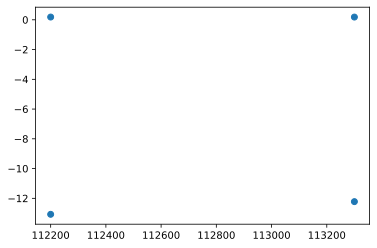

HTML(value="<a href='.\\fig_1.pdf' target='_blank'>.\\fig_1.pdf</a><br>")

In [11]:
pyplot.scatter(
    [literal_eval(key)['p0'] for key in data.keys()],
    [np.nanmax(val['S_max']) for val in data.values()]
)
show_plot("fig_1.pdf")